## Задание по программированию: Размещение баннеров

Представим, что международное круизное агентство *Carnival Cruise Line* решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

In [1]:
import pandas as pd
import numpy as np

Нас будет интересовать файл checkins.dat. Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас.

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

In [2]:
frame = pd.read_csv('checkins.csv', sep='|',skipinitialspace=True).dropna()
frame.head()

C:\Users\Insassin\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
8,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
10,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
11,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396634 entries, 2 to 1021965
Data columns (total 6 columns):
id                  396634 non-null object
user_id             396634 non-null float64
venue_id            396634 non-null float64
latitude            396634 non-null float64
longitude           396634 non-null float64
created_at          396634 non-null object
dtypes: float64(4), object(2)
memory usage: 21.2+ MB


Эта задача — хороший повод познакомиться с алгоритмом `MeanShift`, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в [sklearn user guide](http://scikit-learn.org/stable/modules/clustering.html#mean-shift), а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

**Примечание**: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

In [4]:
subset = frame.values[0:100000, 3:5]

In [5]:
from sklearn.cluster import MeanShift

MS = MeanShift(bandwidth=0.1)
MS.fit(subset)

MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=1, seeds=None)

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт [mapcustomizer.com](https://www.mapcustomizer.com/) имеет функцию `Bulk Entry`, куда можно вставить центры полученных кластеров в формате:

38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071

...

In [6]:
labels = MS.labels_
cluster_centers = MS.cluster_centers_

unique_labels = np.unique(labels)
n_clusters = len(unique_labels)

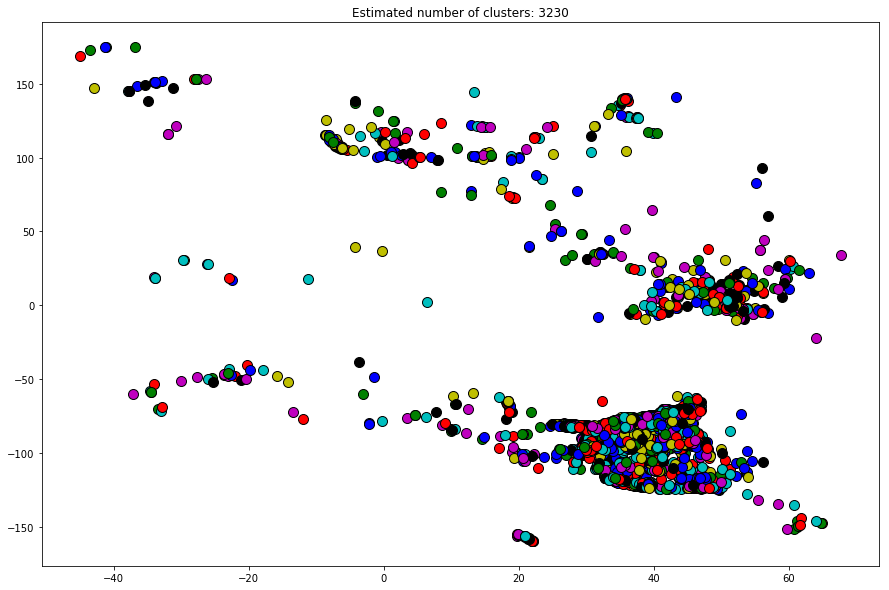

In [7]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmyk')
plt.figure(figsize=(15,10))
for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(subset[my_members, 0], subset[my_members, 1], col + '.')
    
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=10)
plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу *Carnival Cruise Line* адреса всех офисов:

latitude | longitude | city
--------- | ----------- | ------------
33.751277 | -118.188740 | Los Angeles
25.867736 | -80.324116 | Miami
51.503016 | -0.075479 | London
52.378894 | 4.885084 | Amsterdam
39.366487 | 117.036146 | Beijing
-33.868457 | 151.205134 | Sydney

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Примечание**: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

In [8]:
def distance(center1, center2):
    return np.sqrt((center2[0] - center1[0])**2 + (center2[1] - center1[1])**2)

In [9]:
office = [[33.751277, -118.188740],
          [25.867736, -80.324116],
          [51.503016, -0.075479],
          [52.378894, 4.885084],
          [39.366487, 117.036146],
          [-33.868457, 151.205134]]

dict_centers = np.zeros(n_clusters)
for label in unique_labels:
    for lbl in labels:
        if label == lbl:
            dict_centers[label] += 1

minimum = []
min_ind = []
print("distance", "index")
for i in range(n_clusters):
    distances = [distance(cluster_centers[i], of) for of in office]
    if min(distances) < 0.298: # Опытным путём найдено число, чтобы получилось 20 ближайших к офисам центров кластеров
        minimum.append(min(distances))
        min_ind.append(i)
for i in range(20):
    print (minimum[i], min_ind[i])

('distance', 'index')
(0.13410903336184654, 29)
(0.21181053682436798, 42)
(0.070847732427199731, 51)
(0.050058294822787869, 58)
(0.19577945647763628, 87)
(0.18887596060185083, 92)
(0.29497888680045692, 119)
(0.16740596425035326, 166)
(0.22223329073179071, 285)
(0.27130075950667348, 315)
(0.0093533161859922255, 373)
(0.022674066158385495, 405)
(0.007834758163107856, 413)
(0.24065314956287862, 859)
(0.28971896117213125, 1015)
(0.25150208676235281, 1075)
(0.154102829806012, 1798)
(0.19222726571703244, 2212)
(0.26892862728711098, 2232)
(0.27531985669762415, 2791)


Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

In [10]:
def write_answer(center):
    with open("answer.txt", "w") as f:
        f.write(str(center[0]) + ' ' + str(center[1]))
minim = 10
min_index = -1
for i in range(len(minimum)):
    if minimum[i] < minim:
        minim = minimum[i]
        min_index = min_ind[i]

write_answer(cluster_centers[min_index])
print cluster_centers[min_index]

[ -33.86063043  151.20477593]
